# Projeto 1

## Tarefa 1

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

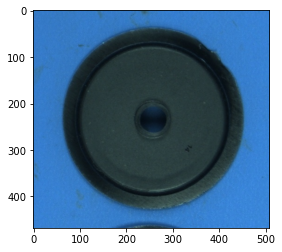

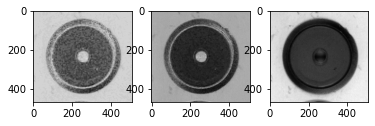

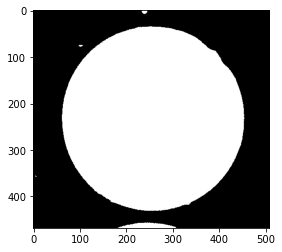

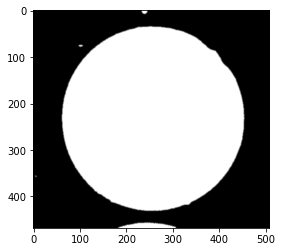

Number of objects detected: 7

Area: 877.0

Area: 2.0

Area: 0.5

Area: 16.5

Area: 2.0

Area: 120814.5
Diameter: 392.20632194982056
Radius: 199
Pixels cinzas: 0

Area: 68.0


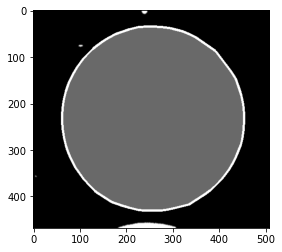

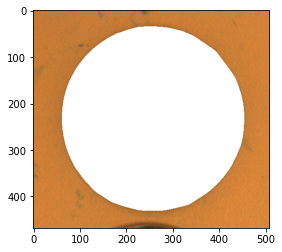

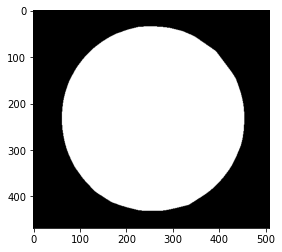

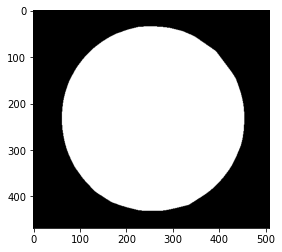

Nro de blobs:  1
Blob_ 1 : X=  256.501708984375  Y=  232.96017456054688  size= 154696.1390069956  ang= -1.0


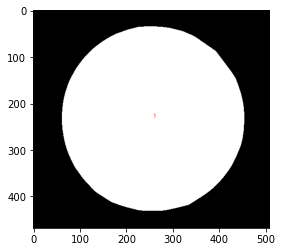

In [86]:

#fig = cv2.imread("OK/Fig_OK_15.jpg")
#fig = cv2.imread("NOK_superficie/Fig_NOK_Superf_03.jpg")
fig = cv2.imread("NOK_borda/Fig_NOK_12.jpg")

#plt.imshow(fig)
#plt.show()


figRGB = cv2.cvtColor(fig,cv2.COLOR_BGR2RGB)
plt.imshow(figRGB)
plt.show()


img_hsv = cv2.cvtColor(fig, cv2.COLOR_BGR2HSV)
(canal_H, canal_S, canal_V) = cv2.split(img_hsv)
plt.figure("Hue")
plt.subplot(1,3,1)
plt.imshow(canal_H,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(canal_S,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(canal_V,cmap='gray')
plt.show()

#print(canal_H)


#Separando as matrizes
[B,G,R] = cv2.split(figRGB)
#plt.imshow(G, cmap='gray')
#plt.show()

#Binarizando a imagem para fazer o cálculo
#fig_bin = np.where((B>120), 255, 0).astype(np.uint8)
#plt.imshow(fig_bin, cmap='gray')
#plt.show()

#gamma = adjust_gamma(canal_S, 5)
#plt.imshow(gamma,cmap='gray')
#plt.show()


thresh = np.where((((canal_H>90) &(canal_V<150) | (canal_S<150))),255,0).astype(np.uint8)
plt.imshow(thresh,cmap='gray')
plt.show()


dst = cv2.GaussianBlur(thresh,(3,3),cv2.BORDER_DEFAULT)
plt.imshow(dst,cmap='gray')
plt.show()

#circles = cv2.HoughCircles(fig, cv2.HOUGH_GRADIENT,1,1)
#print(circles)

contours,hierarchy = cv2.findContours(thresh, 1, 2)
print("Number of objects detected:", len(contours))

#contours[-5] possui o contorno do circulo na figura 1

fig_contor = fig

for c in contours:
    hull = cv2.convexHull(c)
    #img = cv2.drawContours(fig,[hull],0,(255,255,0),2)
    area = cv2.contourArea(c)
    #print("\nArea:",area)
    
    print("\nArea:",area)
    if (area>10000):
        img = cv2.drawContours(dst,[hull],0,(105,100,0),thickness=cv2.FILLED)
        equi_diameter = np.sqrt(4*area/np.pi)
        print("Diameter:", equi_diameter)
        (x,y),radius = cv2.minEnclosingCircle(c)
        center = (int(x),int(y))
        radius = int(radius)
        #cv2.circle(img,center,radius,(156,156,156),thickness=cv2.FILLED)
        print("Radius:",radius)
        #cv2.circle(img,center,3,(255,255,0),1)
        img = cv2.drawContours(dst,[hull],0,(255,255,0),3)
        img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        cinzas = np.sum(img_RGB == [156,156,156])
        print("Pixels cinzas:", cinzas)
        plt.imshow(img_RGB)
        fig_contor = cv2.drawContours(fig,[hull],0,(255,255,255), thickness=cv2.FILLED)
        
            
plt.show()

plt.imshow(fig_contor)
plt.show()

ret2, fig_contor2 = cv2.threshold(fig_contor,250,255,0)
plt.imshow(fig_contor2)
plt.show()

fig_contor3 = cv2.cvtColor(fig_contor2,cv2.COLOR_BGR2GRAY)
plt.imshow(fig_contor3, cmap='gray')
plt.show()

#Blob
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
# Set blob color (0=black, 255=white)
params.filterByColor = True
params.blobColor = 255
# Filter by Area
params.filterByArea = False
# params.minArea = 1
# #params.maxArea = 20000
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.89
#params.maxCircularity = 1
# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.8
#params.maxConvexity = 0.9
# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.9
#params.maxInertiaRatio = 1
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
KP = detector.detect(fig_contor3)
print("Nro de blobs: ",len(KP))
# List parameters (X,Y,size,ang) of each detected keypoints
img1_text = fig_contor2
i=1
for KPi in KP:
    print("Blob_", i, ": X= ", KPi.pt[0], " Y= ", KPi.pt[1], " size=", KPi.size**2, " ang=", KPi.angle)
    img1_text = cv2.putText(img1_text, str(i), (int(KPi.pt[0]),int(KPi.pt[1])), cv2.FONT_HERSHEY_PLAIN, 1,(255,0,0))
    i=i+1

plt.imshow(img1_text, cmap='gray')
plt.show()



#Green para borda
#HUE e SAT para a superfície


#Canal v - rugosidade
#Canal s - borda

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt


path="OK\*.jpg"    #Replace with your folder 
#path("OK\*.jpg") 
k=glob.glob(path)
images=[cv2.imread(images) for images in glob.glob(path)]

print(len(images))     #number of images in folder
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()
    #cv2.imshow("images",images[i])
    #cv2.waitKey(0)

In [ ]:
#Blob
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
# Set blob color (0=black, 255=white)
params.filterByColor = True
params.blobColor = 255
# Filter by Area
params.filterByArea = False
# params.minArea = 1
# #params.maxArea = 20000
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.88
#params.maxCircularity = 1
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.99
#params.maxConvexity = 0.9
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.975
#params.maxInertiaRatio = 1
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
KP = detector.detect(fig_contor3)
print("Nro de blobs: ",len(KP))
# List parameters (X,Y,size,ang) of each detected keypoints
img1_text = fig_contor2
i=1
for KPi in KP:
    print("Blob_", i, ": X= ", KPi.pt[0], " Y= ", KPi.pt[1], " size=", KPi.size**2, " ang=", KPi.angle)
    img1_text = cv2.putText(img1_text, str(i), (int(KPi.pt[0]),int(KPi.pt[1])), cv2.FONT_HERSHEY_PLAIN, 1,(255,0,0))
    i=i+1

plt.imshow(img1_text, cmap='gray')
plt.show()
